In [1]:
from metrics.function_error import SquaredError
from models.linear import LeastSquaresModel
from models.zero_model import ZeroModel
from function_classes.linear import LinearRegression

from torch.distributions.normal import Normal
import torch

from torch import nn


from torch import normal

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
m = Normal(torch.zeros((64, 100, 3)), torch.ones((64, 100 ,3))) #batch size, sequence_length, x_dim

error=SquaredError(function_class=LinearRegression(m))

evals=error.evaluateAtSeenPoints([LeastSquaresModel(), ZeroModel()])

print(evals[0].keys())

print(evals[1])

dict_keys(['accuracy_OLS_driver=None', 'std_OLS_driver=None', 'std_mean_OLS_driver=None', 'max_OLS_driver=None', 'min_OLS_driver=None', 'quantile_OLS_driver=None0.01', 'quantile_OLS_driver=None0.05', 'quantile_OLS_driver=None0.1', 'quantile_OLS_driver=None0.25', 'quantile_OLS_driver=None0.5', 'quantile_OLS_driver=None0.75', 'quantile_OLS_driver=None0.9', 'quantile_OLS_driver=None0.95', 'quantile_OLS_driver=None0.99', 'accuracy_zero_model', 'std_zero_model', 'std_mean_zero_model', 'max_zero_model', 'min_zero_model', 'quantile_zero_model0.01', 'quantile_zero_model0.05', 'quantile_zero_model0.1', 'quantile_zero_model0.25', 'quantile_zero_model0.5', 'quantile_zero_model0.75', 'quantile_zero_model0.9', 'quantile_zero_model0.95', 'quantile_zero_model0.99'])
tensor([[[3.6380e-12, 0.0000e+00, 3.6380e-12,  ..., 3.6380e-12,
          2.2737e-13, 1.2790e-13],
         [1.4552e-11, 3.6380e-12, 3.6380e-12,  ..., 0.0000e+00,
          3.6380e-12, 2.2737e-13],
         [1.4552e-11, 2.2737e-13, 2.2737

tensor([4.7824e-12, 6.1241e-12, 9.2588e-12, 5.1107e-12, 9.6010e-12, 5.1182e-12,
        8.2489e-12, 7.2422e-12, 4.1873e-12, 4.8727e-12, 6.9311e-12, 9.1278e-12,
        1.0896e-11, 1.1683e-11, 1.1425e-11, 7.4579e-12, 1.0432e-11, 8.6720e-12,
        6.5298e-12, 9.0521e-12, 3.3869e-12, 6.7962e-12, 6.9259e-12, 1.2789e-11,
        7.3844e-12, 1.4292e-11, 8.9056e-12, 7.9481e-12, 9.0102e-12, 4.4724e-12,
        8.4456e-12, 5.2867e-12, 5.0020e-12, 8.1800e-12, 5.8347e-12, 7.4682e-12,
        6.0903e-12, 9.4996e-12, 1.1772e-11, 5.8489e-12, 9.7929e-12, 4.8359e-12,
        8.0245e-12, 9.2228e-12, 8.6686e-12, 5.9289e-12, 7.5622e-12, 6.3634e-12,
        8.9324e-12, 8.6186e-12, 1.3537e-11, 9.5664e-12, 1.2696e-11, 6.4879e-12,
        3.4945e-12, 5.7030e-12, 1.0335e-11, 3.4315e-12, 8.1644e-12, 1.0957e-11,
        6.1580e-12, 8.9322e-12, 9.7606e-12, 8.2981e-12, 5.1734e-12, 8.9380e-12,
        1.0191e-11, 9.7506e-12, 5.1246e-12, 4.8763e-12, 1.6398e-11, 8.7226e-12,
        8.9035e-12, 1.0822e-11, 1.3345e-

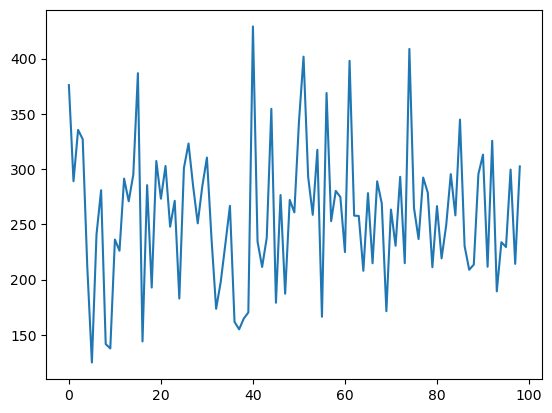

In [3]:
import matplotlib.pyplot as plt

plt.plot(evals[0]['accuracy_zero_model'])

print(evals[0]["accuracy_OLS_driver=None"])

plt.show()